# Header


## Imports, constants

In [23]:
import numpy as np
import random
import matplotlib.pyplot as plt
from time import time_ns as now
from tabulate import tabulate
!pip install memory_profiler
%load_ext memory_profiler
from memory_profiler import memory_usage


lr = 0.1
epoch = 50
eps = 1e-8
s = np.linspace(0, 10, 1000)
X, Y = np.meshgrid(s, s)
default_batch = 1
arithmetic = 0

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Функции, рисующие графики

In [2]:

def show_line(a: float, b: float, l=0, r=10, colour='g', label=''):
    line_xs = [l, r]
    plt.plot(line_xs, [a * x + b for x in line_xs], marker='', c=colour, label=label)
    plt.legend()


def show_descent(points, f):
    def _thin_out(points, epsilon=1e-4):
        ans = [points[0]]
        n = len(points)
        for i in range(1, n):
            if (ans[-1][0] - points[i][0]) ** 2 + (ans[-1][1] - points[i][1]) ** 2 >= epsilon ** 2:
                ans.append(points[i])
        return ans

    lx = max([p[0] for p in points]) - min([p[0] for p in points])
    ly = max([p[1] for p in points]) - min([p[1] for p in points])
    points = _thin_out(points, epsilon=max(lx / 100, ly / 100))
    xs = [point[0] for point in points]
    ys = [point[1] for point in points]
    Xl, Yl = np.meshgrid(np.linspace(min(xs), max(xs), 100),
                         np.linspace(min(ys), max(ys), 100))
    levels = np.unique(sorted([f([p[0], p[1]]) for p in points]))
    plt.contour(Xl, Yl, f([Xl, Yl]), levels=levels)
    plt.plot(xs, ys, '.-')
    plt.show()


## Аналитическое решение

In [3]:

def exact_ans(points, draw=False, log=False):
    arr = np.ones((len(points), 2), dtype=float)
    y = np.zeros(len(points))
    for i in range(len(points)):
        arr[i][1] = points[i][0]
        y[i] = points[i][1]
    ans = np.linalg.inv(np.transpose(arr) @ arr) @ np.transpose(arr) @ y
    if draw:
        xs = [p[0] for p in points]
        show_line(ans[1], ans[0], l=min(xs), r=max(xs), colour='r', label='Exact')
    if log:
        print('Exact: ', [ans[1], ans[0]])
    return [ans[1], ans[0]]

print(exact_ans([[0.9997266359324652, 0.007287948283305911], [1.009480336631675, -0.004159204615635062], [1.0022489839701796, 0.008841562734875382]]))


[-1.3118362446615215, 1.320835793128717]


## Генерация случайных точек

Первый метод -- псевдослучайная генерация. Точки случайно бросаются в полосу `|y-ax-b| < delta`

In [4]:

def generate_dots_simple(n: int, a: float, b: float, delta=1):
    ch = 10.0 / n
    # print('Line: ', a, 'x+', b, sep='')
    return [[ch * i, a * i * ch + b + random.uniform(-delta, delta)] for i in range(1, n + 1)]


def generate_dots_advanced(n: int):
    return [[random.uniform(0, 10), random.uniform(0, 10)] for _ in range(n)]


## Линейная регрессия

In [5]:

def calc_grad(w, points, batch=default_batch):
    global arithmetic
    arithmetic += 20 * batch + 3
    res = np.array([0] * 2, float)
    a = w[0]
    b = w[1]
    n = len(points)
    for i in range(batch):
        ind = (calc_grad.counter * batch + i) % n
        if ind == 0:
            random.shuffle(calc_grad.order)
        x = points[calc_grad.order[ind]][0]
        y = points[calc_grad.order[ind]][1]
        # print(calc_grad.order[ind], res[0], res[1], x, y, a, b)
        res[0] += 2 * a * x * x + 2 * b * x - 2 * x * y
        res[1] += 2 * b + 2 * a * x - 2 * y
    res[0] /= n
    res[1] /= n
    calc_grad.counter += 1
    return res


def linear_regression_extend(points, calc_point, draw=False, draw_descent=False,
                             log=False, batch=default_batch):
    def _help(points, calc_point, draw, draw_descent, log, batch):
        global arithmetic
        calc_grad.counter = 0
        dl, dr = min(points), max(points)
        a = (dr[1] - dl[1]) / (dr[0] - dl[0])
        b = dl[1] - a * dl[0]
        # print('Start point:', a, b)
        w = np.array([1, 1], float)
        tmp = 2
        descent_points = [w]
        calc_grad.order = [i for i in range(len(points))]
        while calc_grad.counter * batch < epoch * len(points):
            tmp += 2
            w = calc_point(w, points, lambda w, p: calc_grad(w, p, batch))
            descent_points.append(w)
        if draw_descent:
            show_descent(descent_points,
                         lambda x: sum([(x[0] * p[0] + x[1] - p[1]) ** 2 for p in points]) / len(points))
        if draw:
            xs = [point[0] for point in points]
            ys = [point[1] for point in points]
            plt.scatter(xs, ys)
            show_line(w[0], w[1], l=min(xs), r=max(xs), colour='g', label='SGD')
        if log:
            print('SGD: ', w)
        arithmetic += tmp
        return [w, descent_points]
    return _help(points, calc_point, draw, draw_descent, log, min(batch, len(points)))


def linear_regression(points, mod, draw=False, draw_descent=False, log=False, batch=default_batch):
    calc_point = None
    if mod.__name__ == 'Default':
        calc_point = mod(n=len(points), batch=batch)
    else:
        calc_point = mod()
    return linear_regression_extend(points, calc_point, draw, draw_descent, log, batch)[0]


# Задание 2. Learning rate scheduling

## Экспоненциальная функция изменения шага

In [6]:

def get_exp_lr(count_dots, batch, alpha):
    get_exp_lr.step = 0.99

    def help(cur):
        global arithmetic
        arithmetic += 2
        return cur * get_exp_lr.step * cur

    return help


## Ступенчатая функция изменения шага

In [7]:

def get_step_lr(count_dots, batch, alpha):
    def help(cur):
        global arithmetic
        arithmetic += 1
        get_step_lr.counter += 1
        if get_step_lr.counter >= get_step_lr.steps:
            get_step_lr.counter = 0
            cur -= get_step_lr.step
        return cur

    get_step_lr.steps = 10
    get_step_lr.step = alpha / (count_dots * epoch) * get_step_lr.steps
    get_step_lr.counter = 0
    return help


# Задание 3. Модификации градиентного спуска

## Обычный градиентный спуск

In [8]:

def Default(n: int = 100, batch: int = default_batch):
    Default.alpha = 0.01
    func = get_step_lr(n, batch, Default.alpha)

    def _help(w, points, grad):
        Default.alpha = func(Default.alpha)
        return w - Default.alpha * grad(w, points)

    return _help


## Momentum

In [9]:

def Momentum():
    def _help(w, points, grad, alpha=0.001, beta=0.9):
        global arithmetic
        arithmetic += 3
        if Momentum.v is None:
            Momentum.v = -alpha * grad(w, points)
        else:
            arithmetic += 1
            Momentum.v = beta * Momentum.v - alpha * grad(w, points)
        return w + Momentum.v
    Momentum.v = None
    return _help


## Nesterov

In [10]:

def Nesterov():
    def _help(w, points, grad, alpha=0.01, beta=0.9):
        global arithmetic
        arithmetic += 3
        if Nesterov.v is None:
            Nesterov.v = -alpha * grad(w, points)
            # Nesterov.v = np.array([-alpha], float) * grad(w, points)
        else:
            arithmetic += 3
            Nesterov.v = beta * Nesterov.v - alpha * grad(w + beta * Nesterov.v, points)
            # Nesterov.v = np.array([beta]) * Nesterov.v - np.array([alpha]) * grad(w + np.array([beta]) * Nesterov.v, points)
        return w + Nesterov.v
    Nesterov.v = None
    return _help


## Adagrad

In [11]:

def Adagrad():
    def _help(w, points, grad, alpha=100):
        global arithmetic
        arithmetic += 6
        g = grad(w, points)
        if Adagrad.G is None:
            Adagrad.G = g * g
        else:
            arithmetic += 1
            Adagrad.G += g * g
        return w - alpha / ((Adagrad.G + eps) ** 0.5) * g
    Adagrad.G = None
    return _help


## RMSprop

In [12]:

def RMSprop():
    def _help(w, points, grad, alpha=1, gamma=0.99, eps=1e-8):
        global arithmetic
        arithmetic += 6
        g = grad(w, points)
        if RMSprop.G is None:
            RMSprop.G = (1 - gamma) * g * g
        else:
            arithmetic += 4
            RMSprop.G = gamma * RMSprop.G + (1 - gamma) * g * g
        return w - alpha / ((RMSprop.G + eps) ** 0.5) * g
    RMSprop.G = None
    return _help


## Adam

In [13]:

def Adam():
    def _help(w, points, grad, alpha=1, beta1=0.9, beta2=0.99, eps=1e-8):
        global arithmetic
        arithmetic += 8
        g = grad(w, points)
        Adam.deg += 1
        if Adam.v is None:
            Adam.v = (1 - beta1) * g
        else:
            arithmetic += 3
            Adam.v = beta1 * Adam.v + (1 - beta1) * g
        if Adam.G is None:
            Adam.G = (1 - beta2) * g * g
        else:
            arithmetic += 3
            Adam.G = beta2 * Adam.G + (1 - beta2) * g * g
        return w - alpha / ((Adam.G + eps) ** 0.5) * (Adam.v / (1 - beta1 ** Adam.deg))
    Adam.v = None
    Adam.G = None
    Adam.deg = 0
    return _help


# Задание 4. Сравнение алгоритмов

## Методы для сбора статистик

In [14]:

Modifications = [Default, Momentum, Nesterov, Adagrad, RMSprop, Adam]


# returns [time, delta, memory]
def profile_task(dots, batch, modification, draw=False, draw_descent=False, log=False):
    n = len(dots)
    global arithmetic, time
    arithmetic = 0
    start = now()
    a, b = linear_regression(dots, modification, batch=batch, draw=draw, draw_descent=draw_descent, log=log)
    tmp = now() - start
    mem = memory_usage(lambda: linear_regression(dots, modification, batch=batch))
    exact_ans(dots, draw=draw)
    if draw:
        plt.show()
    return [tmp, sum([(a * dot[0] + b - dot[1]) ** 2 for dot in dots]) / n, max(mem)]


def profile_all_tasks(n: int, test_cnt: int = 100):
    stats = [['method', 'batch', 'arithmetic', 'delta', 'time (ns)', 'memory (MB)']]
    for mod in Modifications:
        for batch in range(1, n + 1):
            time = 0
            delta = 0
            memory = 0
            for _ in range(test_cnt):
                dots = generate_dots_simple(n, random.uniform(-10, 10), random.uniform(-10, 10), 1)
                t, d, m = profile_task(dots, batch, mod)
                time += t
                delta += d
                memory += m
            stats.append([mod.__name__, batch, arithmetic, delta / test_cnt,
                          int(time / test_cnt), memory])
    return tabulate(stats, headers='firstrow', tablefmt='fancy_grid')


def check_test(dots, draw=False, draw_descent=False, log=False):
    n = len(dots)
    stats = [['method', 'batch', 'arithmetic', 'delta', 'time (ms)', 'memory (MB)', 'reliability']]
    for mod in Modifications:
        min_time = 1e190
        min_delta = 1e190
        min_memory = 1e190
        min_batch_by_time = -1
        min_batch_by_delta = -1
        min_batch_by_memory = -1
        for batch in range(1, n + 1):
            time, delta, memory = profile_task(dots, batch, mod)
            if time < min_time:
                min_time = time
                min_batch_by_time = batch
            if delta < min_delta:
                min_delta = delta
                min_batch_by_delta = batch
            if memory < min_memory:
                min_memory = memory
                min_batch_by_memory = batch
            rel = 0
            for _ in range(100):
                ppp = generate_dots_simple(n, random.uniform(-10, 10), random.uniform(-10, 10), 10)
                a1, b1 = linear_regression(dots, mod, batch=batch)
                a0, b0 = exact_ans(dots)
                delta1 = sum([(a1 * dot[0] + b1 - dot[1]) ** 2 for dot in ppp]) / n
                delta2 = sum([(a0 * dot[0] + b0 - dot[1]) ** 2 for dot in ppp]) / n
                if abs(delta1 - delta2) < 20:
                    rel += 1
            stats.append([mod.__name__, batch, arithmetic,
                          str(round(delta, 5)).replace('.', ','),
                          str(round(int(time) / 1000000.0, 4)).replace('.', ','),
                          str(memory).replace('.', ','),
                          str(rel / 100).replace('.', ',')])
        if draw:
            print(mod.__name__, ' (', min_batch_by_delta, ')', sep='')
            profile_task(dots, min_batch_by_delta, mod, draw=draw, draw_descent=draw_descent)
            print()
    return tabulate(stats, headers='firstrow')


def check_on_random_test(n: int, draw=True):
    dots = generate_dots_simple(n, random.uniform(-10, 10), random.uniform(-10, 10), 10)
    return check_test(dots, log=False, draw=draw, draw_descent=draw)


## Сбор статистики

In [25]:

# print(profile_all_tasks(10))
print(check_on_random_test(100, draw=False))


method      batch    arithmetic  delta      time (ms)    memory (MB)    reliability
--------  -------  ------------  ---------  -----------  -------------  -------------
Default         1      13390206  47,40976   68,3011      196,35546875   0,48
Default         2      11845206  45,62265   54,0606      196,35546875   0,55
Default         3      11332472  45,06204   40,4738      196,35546875   0,53
Default         4      11072706  44,78727   40,0218      196,35546875   0,54
Default         5      10918206  44,63065   57,3288      196,35546875   0,57
Default         6      10928944  44,52842   31,598       196,35546875   0,51
Default         7      10856768  44,45505   32,1968      196,35546875   0,59
Default         8      10686456  44,40232   32,1382      196,35546875   0,51
Default         9      10755472  44,37381   30,4332      196,35546875   0,51
Default        10      10712208  44,32956   29,6046      196,35546875   0,56
Default        11      10694528  44,2994    27,7631      196

# Задание 5. Построение траекторий спуска различных алгоритмов

[[0.1, -9.597633725630905], [0.2, -0.12603857476954783], [0.30000000000000004, 2.2102555707895633], [0.4, 0.8650343202764947], [0.5, -11.13349048421045], [0.6000000000000001, -6.878292590413191], [0.7000000000000001, 2.4118809009481206], [0.8, -0.9830575322308501], [0.9, 1.075803603755939], [1.0, -5.658279441090367], [1.1, 4.346989160344305], [1.2000000000000002, 0.3843680052371985], [1.3, -0.47420231963485815], [1.4000000000000001, -2.642744250223818], [1.5, 4.193046101353024], [1.6, 2.2177523497851235], [1.7000000000000002, -0.08822017338172117], [1.8, 12.894526550119277], [1.9000000000000001, -0.5958676923306063], [2.0, 2.538774065226346], [2.1, 6.422113806701353], [2.2, 10.511315085015692], [2.3000000000000003, 10.3862099876127], [2.4000000000000004, 8.62880987668982], [2.5, 17.01883287333169], [2.6, 8.456181222280916], [2.7, 16.137209060488317], [2.8000000000000003, 13.159526144152924], [2.9000000000000004, 2.222148483785329], [3.0, 10.530842106111159], [3.1, 6.613404306116582], [

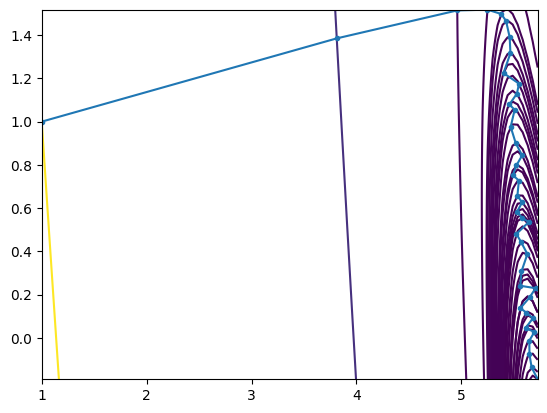

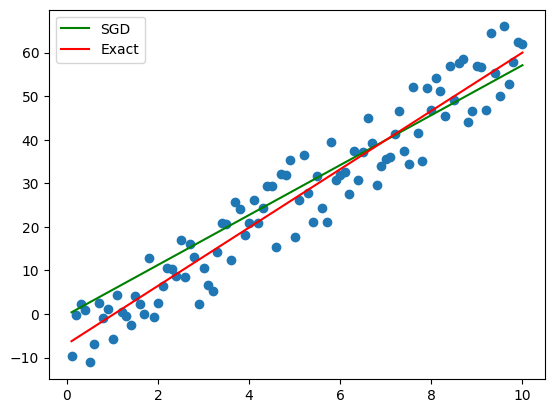


Momentum (1)


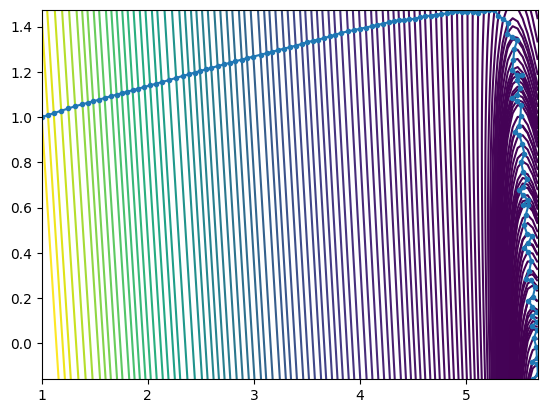

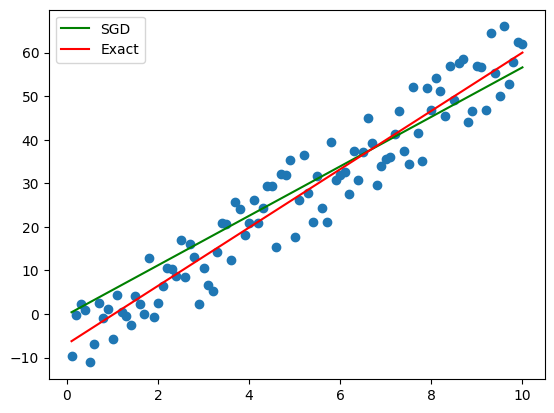


Nesterov (100)


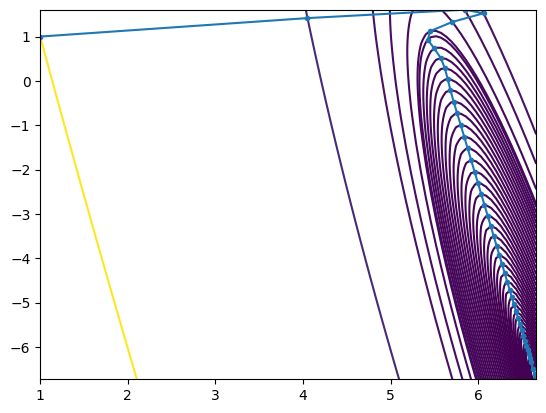

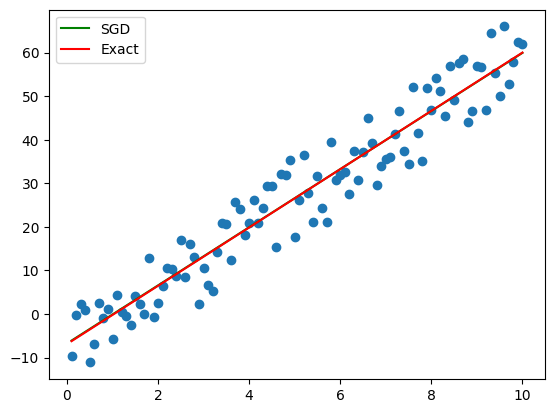


Adagrad (22)


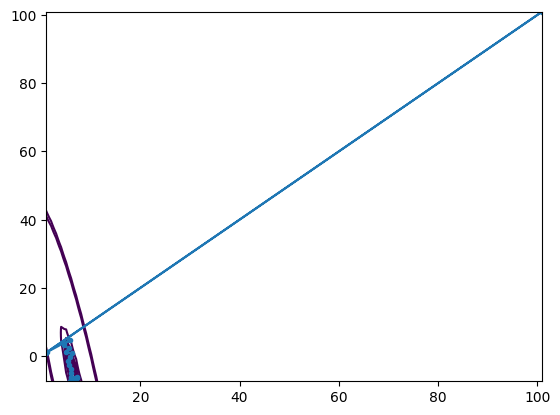

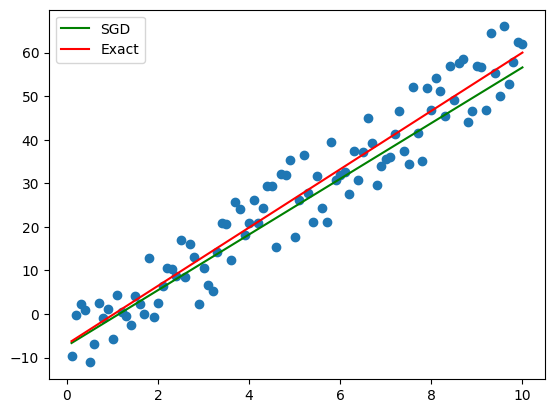


RMSprop (1)


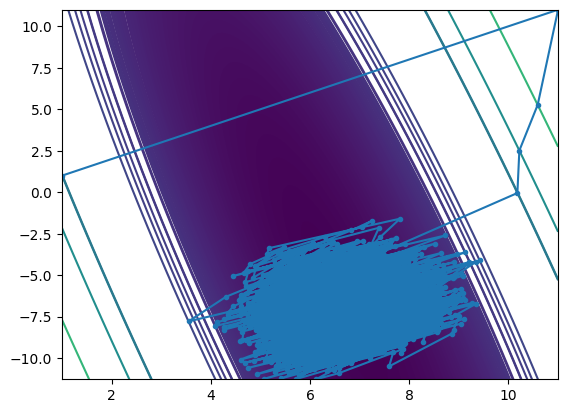

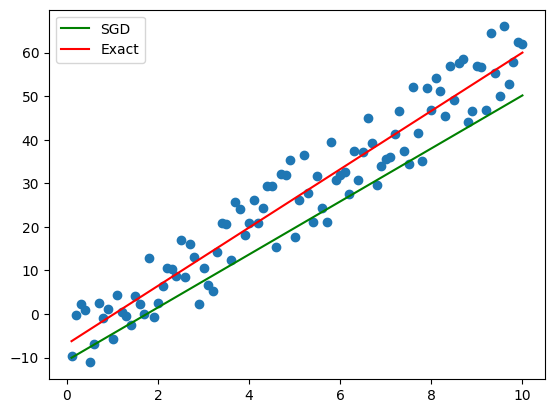


Adam (34)


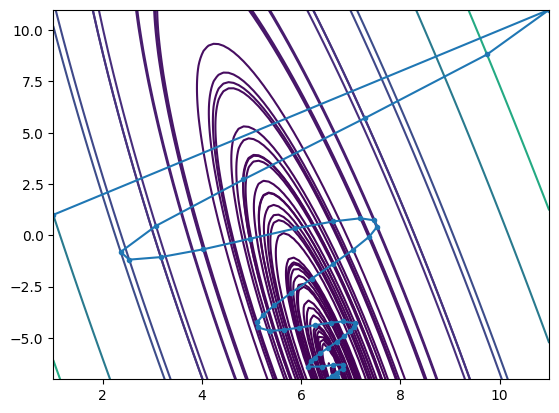

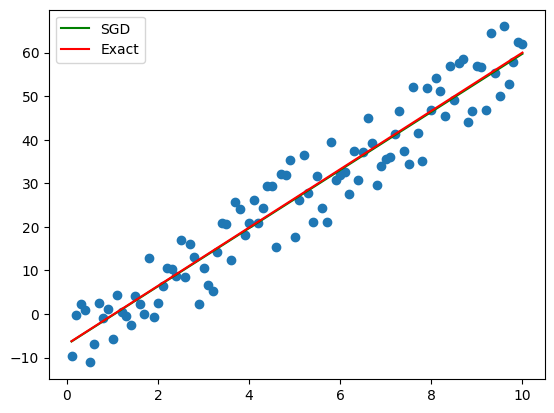


method      batch    arithmetic  delta      time (ms)    memory (MB)    reliability
--------  -------  ------------  ---------  -----------  -------------  -------------
Default         1      13390206  44,67095   118,8243     155,140625     0,46
Default         2      11845206  43,05175   48,9106      155,140625     0,49
Default         3      11332472  42,54822   40,8141      155,140625     0,56
Default         4      11072706  42,31619   37,8593      155,140625     0,57
Default         5      10918206  42,16119   77,2142      155,140625     0,58
Default         6      10928944  42,06568   33,1928      155,140625     0,51
Default         7      10856768  42,02278   30,6406      155,15234375   0,52
Default         8      10686456  41,95955   66,1478      155,15234375   0,61
Default         9      10755472  41,97605   29,7242      155,15234375   0,52
Default        10      10712208  41,89132   31,9736      155,15234375   0,56
Default        11      10694528  41,90492   27,9744      15

In [24]:

# dots = generate_dots_simple(100, random.uniform(-10, 10), random.uniform(-10, 10), delta=10)
dots = [[0.1, -9.597633725630905], [0.2, -0.12603857476954783], [0.30000000000000004, 2.2102555707895633], [0.4, 0.8650343202764947], [0.5, -11.13349048421045], [0.6000000000000001, -6.878292590413191], [0.7000000000000001, 2.4118809009481206], [0.8, -0.9830575322308501], [0.9, 1.075803603755939], [1.0, -5.658279441090367], [1.1, 4.346989160344305], [1.2000000000000002, 0.3843680052371985], [1.3, -0.47420231963485815], [1.4000000000000001, -2.642744250223818], [1.5, 4.193046101353024], [1.6, 2.2177523497851235], [1.7000000000000002, -0.08822017338172117], [1.8, 12.894526550119277], [1.9000000000000001, -0.5958676923306063], [2.0, 2.538774065226346], [2.1, 6.422113806701353], [2.2, 10.511315085015692], [2.3000000000000003, 10.3862099876127], [2.4000000000000004, 8.62880987668982], [2.5, 17.01883287333169], [2.6, 8.456181222280916], [2.7, 16.137209060488317], [2.8000000000000003, 13.159526144152924], [2.9000000000000004, 2.222148483785329], [3.0, 10.530842106111159], [3.1, 6.613404306116582], [3.2, 5.3079035638433805], [3.3000000000000003, 14.318377379320388], [3.4000000000000004, 20.929687749535674], [3.5, 20.612110845305992], [3.6, 12.444594370272357], [3.7, 25.70100250299897], [3.8000000000000003, 24.192117387298037], [3.9000000000000004, 18.069222399725742], [4.0, 20.9258988631169], [4.1000000000000005, 26.21482934575629], [4.2, 20.88309791996417], [4.3, 24.387509674829456], [4.4, 29.26866705102762], [4.5, 29.479910601438647], [4.6000000000000005, 15.43284276817171], [4.7, 32.22122896591887], [4.800000000000001, 31.82446960518453], [4.9, 35.45080213838068], [5.0, 17.694798819834485], [5.1000000000000005, 26.154183401277372], [5.2, 36.398520804788504], [5.300000000000001, 27.75015394603494], [5.4, 21.18114158981684], [5.5, 31.6261482960496], [5.6000000000000005, 24.291450691815044], [5.7, 21.064361629097704], [5.800000000000001, 39.435291952254445], [5.9, 30.69465679659282], [6.0, 31.81167805496972], [6.1000000000000005, 32.61653829012463], [6.2, 27.445891321608073], [6.300000000000001, 37.332382205972436], [6.4, 30.688559041561277], [6.5, 37.20196631572618], [6.6000000000000005, 45.03260950473303], [6.7, 39.260386503656804], [6.800000000000001, 29.575828778356577], [6.9, 34.03986527148359], [7.0, 35.66567692367674], [7.1000000000000005, 35.96200369462359], [7.2, 41.267516380674905], [7.300000000000001, 46.539162086124435], [7.4, 37.403535783630275], [7.5, 34.38410576825663], [7.6000000000000005, 52.020796326878425], [7.7, 41.61807192334677], [7.800000000000001, 35.11014251832414], [7.9, 51.95018073385223], [8.0, 46.76009632264023], [8.1, 54.10873043854077], [8.200000000000001, 51.15557990986193], [8.3, 45.39864737562293], [8.4, 56.95082049460537], [8.5, 49.14367172139736], [8.6, 57.63125568256267], [8.700000000000001, 58.62951123765039], [8.8, 43.99704922641109], [8.9, 46.62975173732299], [9.0, 56.918059631372344], [9.1, 56.69349225695065], [9.200000000000001, 46.783111688553035], [9.3, 64.43157268601249], [9.4, 55.289128195709836], [9.5, 49.96711154201032], [9.600000000000001, 65.98427602873556], [9.700000000000001, 52.894253989033096], [9.8, 57.82548468592059], [9.9, 62.39619062083865], [10.0, 61.893699004507965]]
print(dots)
ananas = [6.690597231830747, -6.913410323148287]
print(sum([(ananas[0] * p[0] + ananas[1] - p[1]) ** 2 for p in dots]) / len(dots))
print(check_test(dots, draw=True, draw_descent=True))


# Задание 1. Исследование сходимости с разными размерами батча

## Исследование сходимости с разными размерами батча

[[0.1, 7.843850736757599], [0.2, 1.934911916794693], [0.30000000000000004, -0.9052769235285965], [0.4, 3.6061207356953084], [0.5, 1.193055499744176], [0.6000000000000001, 3.284597264568581], [0.7000000000000001, -5.069355149870935], [0.8, -4.004942417686385], [0.9, 2.401661033269022], [1.0, 0.9102342264830634], [1.1, -2.8073564415448793], [1.2000000000000002, -4.0669563047848785], [1.3, -1.7882822953161135], [1.4000000000000001, -7.49899320443818], [1.5, -6.023128680389877], [1.6, 0.12019951509161153], [1.7000000000000002, -5.203074360969756], [1.8, -10.222775242307364], [1.9000000000000001, -3.9737098622307574], [2.0, -8.864900121412166], [2.1, -11.906462947772154], [2.2, -7.812721423931981], [2.3000000000000003, -9.715032485974845], [2.4000000000000004, -6.395877474209572], [2.5, -12.533470080774139], [2.6, -13.5991407262397], [2.7, -10.775243572838546], [2.8000000000000003, -10.244870657821709], [2.9000000000000004, -9.931118620077791], [3.0, -8.441851329248088], [3.1, -15.519376530

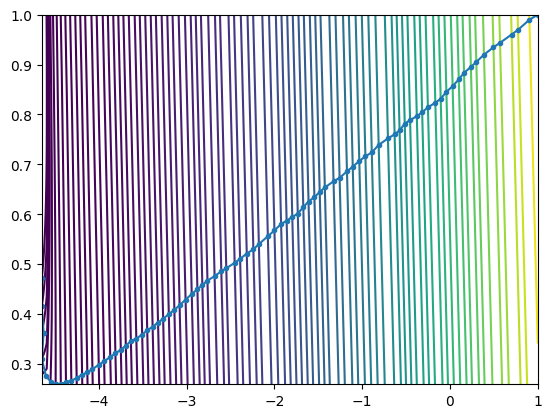

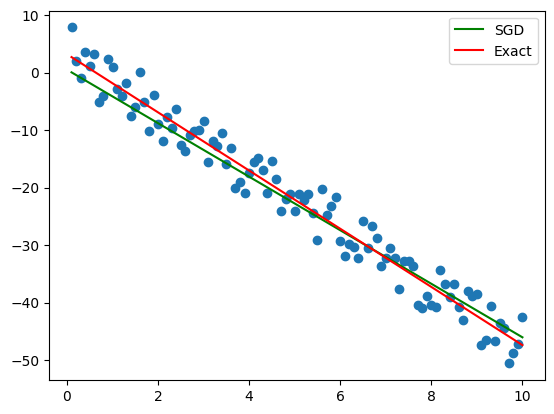


Batch=11


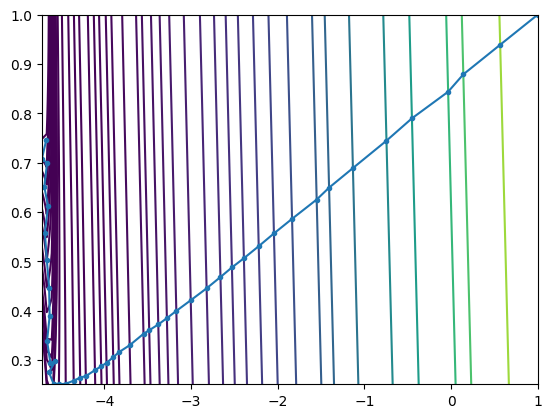

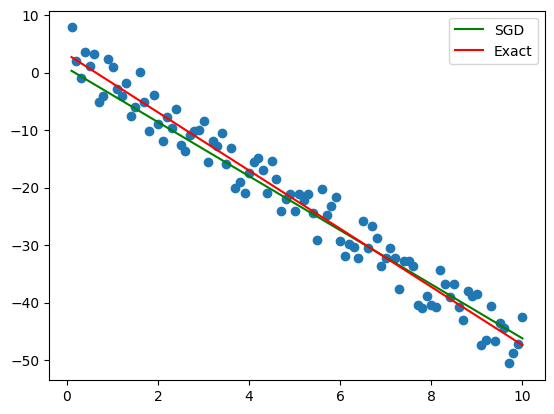


Batch=21


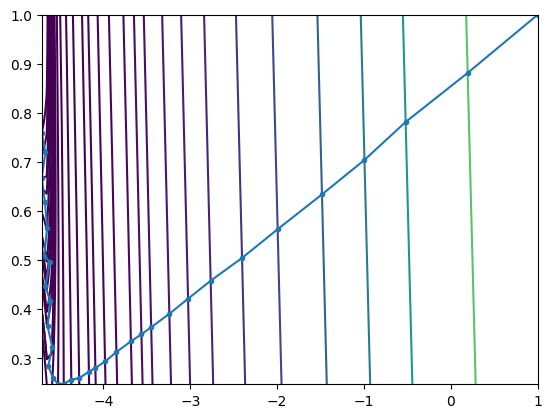

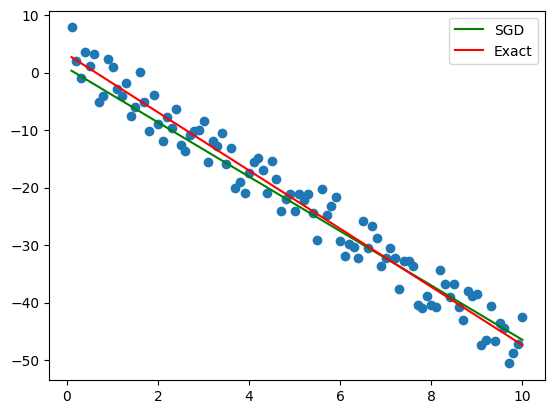


Batch=31


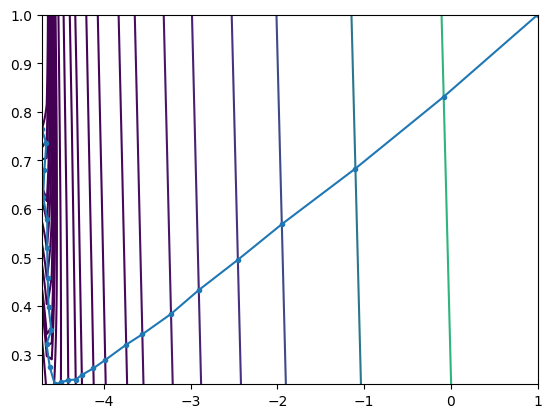

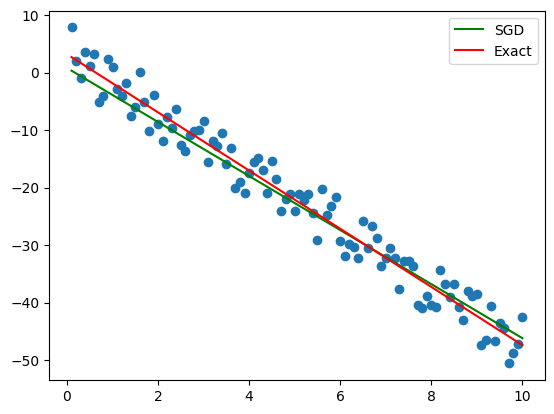


Batch=41


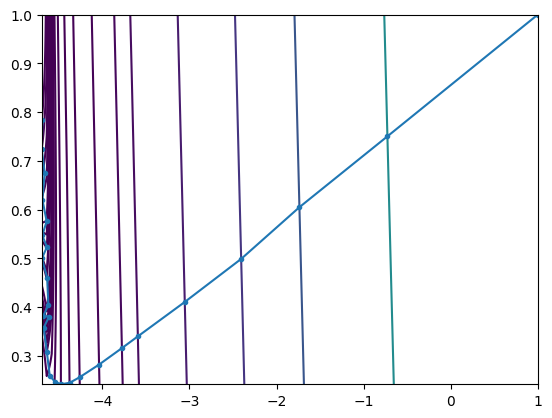

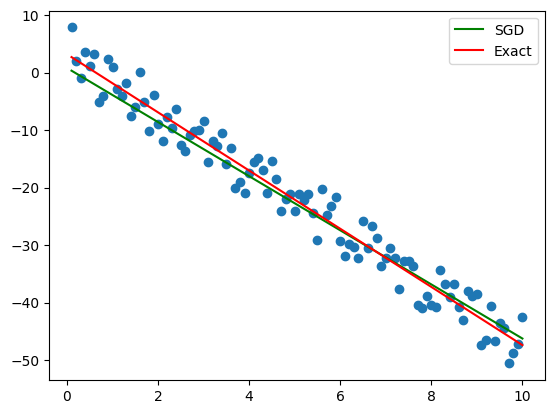


Batch=51


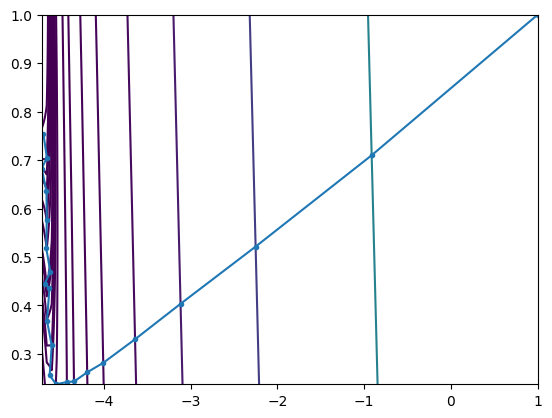

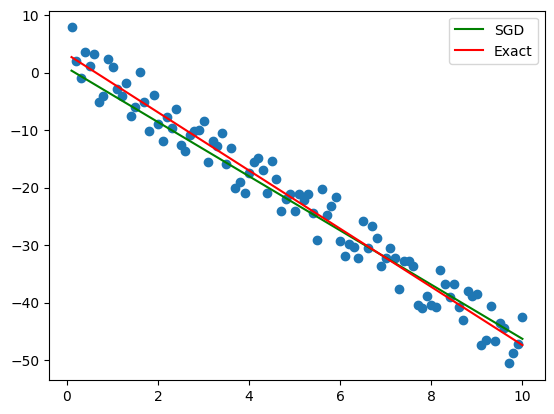


Batch=61


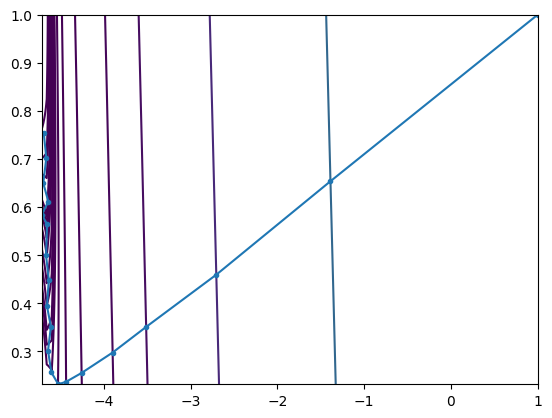

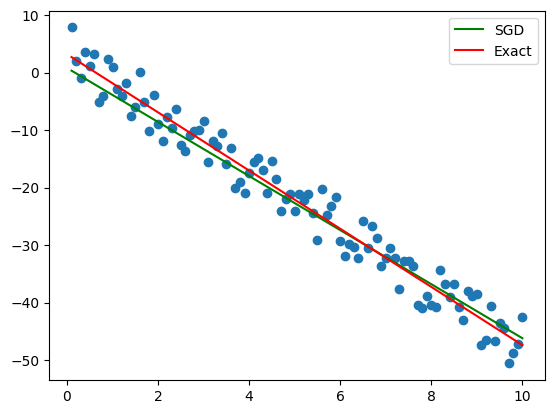


Batch=71


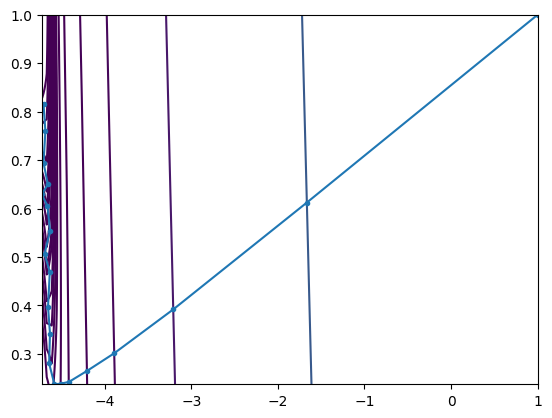

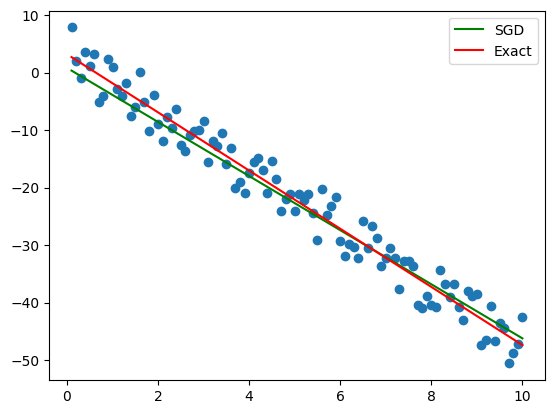


Batch=81


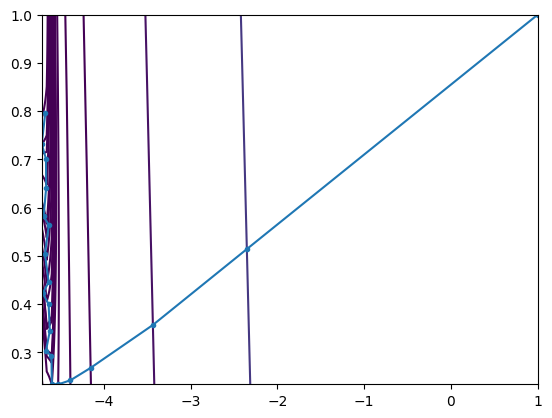

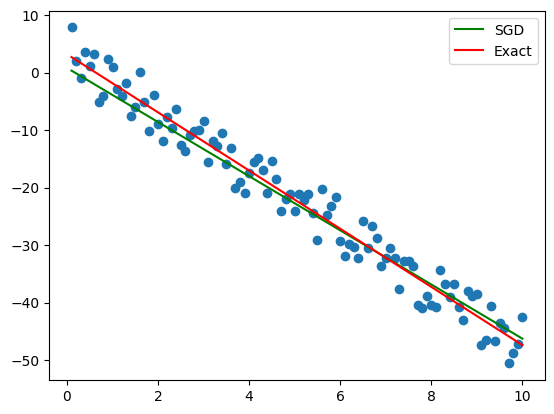


Batch=91


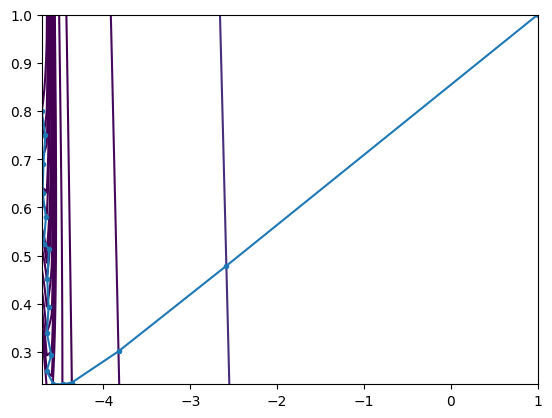

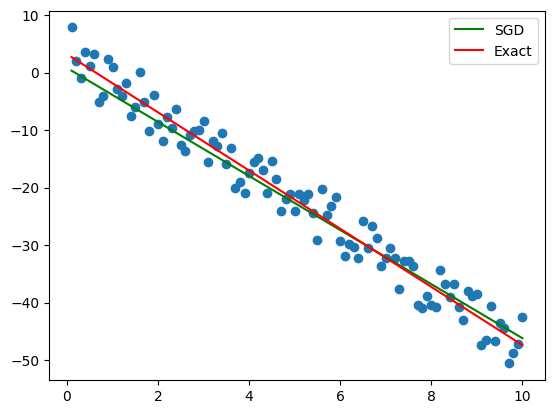

In [21]:

n = 100
dots = generate_dots_simple(n, random.uniform(-10, 10), random.uniform(-10, 10), delta=5)
print(dots)

with open('sample_data/Default', 'w') as f:
    f.write('batch delta\n')
    for b in range(1, n + 1, 10):
        print('\nBatch=', b, sep='')
        default_batch = b
        f.write(str(b) + ' ' + str(profile_task(dots, b, Default, draw=True, draw_descent=True)[1]).replace('.', ',') + '\n')
